# Analysis of MD simulations of Protein Crystals - Bragg

$\text{David Wych}^{1, 2}, \text{Michael E. Wall}^{1}$

1. Computer, Computational and Statistical Sciences Division, Los Alamos National Laboratory, Los Alamos, NM 87545, USA
2. Center for Nonlinear Studies, Los Alamos National Laboratory, Los Alamos, NM 87545, USA

## Generating Bragg data from a crystalline MD trajectory

In the notebook "Analysis of MD Simulations of Protein Crystals -- Diffuse", we show how to compute structure factors from an MD simulation trajectory. The lunus script `xtraj.py` takes in a `GROMACS` `.xtc` trajectory file and a topology file (in the `.pdb` format) and computes the structure factors. To produce structure factors that can be compared with those from experiment, one needs to supply `unit_cell` and `space_group` information from the `CRYST1` record of the crystal structure, and the computed structure factors are transformed to match the structure of those that would be measured in experiment.

In that notebook, we were working with data from a simulation of _staphylococcal nuclease_. So, the `fcalc.mtz` structure factor files we produced in that notebook could be used as a complement to analysis of the structure and dynamcis of _that_ system. In this notebook, were going to be using a different dataset, produced from a crystalline MD simulation of _protein kinase A_. This data will be used to reproduce some of the findings from our paper, published in _Acta Crystallographica Section D_ entitled "[Molecular Dynamics Simulation Methods for Macromolecular Crystallography](https://journals.iucr.org/d/issues/2023/01/00/lp5065/)".

In this notebook, we'll cover:

- Refining a structural model against data computed from an MD simulation of a crystalline protein system.
- Analyzing the B-factors from the simulated trajectory, and the model refined against the MD data (with some caveats concerning restrained and unrestrained simulation).
- Reverse propagating a supercell simulation frame to produce a protein structural ensemble that can be used to complement the Bragg analysis.

---

We can use the `fcalc.mtz` file produced by `lunus`' `xtraj.py` to calculate the Bragg scattering intensities from our MD trajectetory. Below is an example script that takes in a `fcalc.mtz` file and produces an `iobs.mtz` intensity data file, with the intensities (squared structure factors) and variances (10 times the intensities themselves) in columns 1 and 2.

```bash
#!/usr/bin/env bash
# generate_iobs.sh
#
# The first argument, $1, is the structure factor mtz file
# The second arguement, $2 is the name of the output file
if [ -e iobs.mtz ]; then
  rm iobs.mtz
fi

sftools <<EOF
read $1
calc J col Iobs = col 1 col 1 * 100. /
calc Q col SIGIobs = col 1 10. /
write $2
quit
EOF

```

In [1]:
!bash ./code/generate_iobs.sh data/fcalc_full.mtz iobs_full.mtz
!bash ./code/generate_iobs.sh data/fcalc_wat.mtz iobs_water.mtz
!bash ./code/generate_iobs.sh data/fcalc_prot.mtz iobs_protein.mtz



OPTIONS ARE:

    ABSENT      MODE      CALC  CHECKHKL  COMPLETE    CORREL
    DELETE    EXPAND       FFT    FOURPT    GETSYM    HLCONV
       I2F      LIST       MAP    MAP2SF     MAPIN  MAPLIMIT
    MAPOUT   MAPSTAT     MERGE   OPTION1   PHASHFT      PLOT
     PURGE      READ    REDUCE   REINDEX     RFREE    SELECT
       SET      SORT      STOP    WINDOW     WRITE

>> give your option (or hit <return> to list options)

selected: READ    



 OPENED INPUT MTZ FILE 
 Logical Name: data/fcalc_full.mtz   Filename: data/fcalc_full.mtz 


Reading file : data/fcalc_full.mtz                                              
With format  : MTZ

 SYMINFO file set to /Applications/ccp4-8.0/lib/data/syminfo.lib 
  !!! WARNING, sort order improper !!!

  Sort order will be set to 1 2 3
  Use option SORT [h k l] later if needed
The following columns will be read:

TYPE  LABEL

  F   FWT                                                                       
  P   PHIFWT                              


 WRITTEN OUTPUT MTZ FILE 
 Logical Name: iobs_protein.mtz   Filename: iobs_protein.mtz 


>> give your option (or hit <return> to list options)

selected: QUIT    



Normal end program sftools



In [3]:
!mv iobs_full.mtz files_for_refinement/
!mv iobs_water.mtz files_for_refinement/
!mv iobs_protein.mtz files_for_refinement/

## Refinining a structure against MD data

It is possible to refine a protein structure against the data computed from the MD trajectory in exactly the same way as one would refine a structure against experimental data.

We use `phenix` to perform this refinement. In the refinement parameter definition `.eff` file, we specify the `iobs_protein.mtz` or `iobs_full.mtz` files as the X-ray data for refinement, and we use the `starting_structure.pdb` file as the starting structural model.

The data we're going to be working with comes from our recent _Acta Cryst. D._ publication, "Molecular Dynamics Simulations for Macromolecular Crystallography". These `.mtz` files were calcualted from the 90-100ns segment of a crystalline MD simulation of _protein kinase A_ (PKA).

If we want to argue that the MD can provide information that is useful to crystallographic refinement, first we need a control to compare to. 

Below, we just refine the starting structure against the experimental data
- the flag `--unused_ok` just tells phenix that if there are any refinement parameters we aren't defining in the `.eff` file, that's ok

In [4]:
!phenix.refine ./files_for_refinement/single_structure_refinement.eff --unused_ok

# Date 2023-02-07 Time 13:29:31 MST -0700 (1675801771.34 s)
#phil __OFF__

Command line arguments: "./files_for_refinement/single_structure_refinement.eff" "--unused_ok"

USER = dwych
PID = 12533

-------------------------------------------------------------------------------
  PHENIX: Python-based Hierarchical ENvironment for Integrated Xtallography
  Version: 1.20.1
  Release tag: 4487
  Platform: mac-intel-osx-x86_64
  User: dwych
-------------------------------------------------------------------------------

              phenix.refine: Macromolecular Structure Refinement

-------------------------------------------------------------------------------

Phenix developers include:
  Paul Adams, Pavel Afonine, Gabor Bunkoczi, Tom Burnley, Vincent Chen, 
  Youval Dar, Ian Davis, Eli Draizen, Nathaniel Echols, Richard Gildea, 
  Piet Gros, Ralf Grosse-Kunstleve, Jeffrey Headd, Bradley Hintze, Li-Wei Hung, 
  Tom Ioerger, Dorothee Liebschner, Airlie McCoy, Erik McKee, Nigel Moriarty, 
 


 ******************************************************************
 INFO: Some parts of this job will make use of multiple processors:
 ******************************************************************

   nproc = 4

 Please ask your system administrator for advice about this, in particular if
 you run this job through a queuing system.

  Monomer Library directory:
    "/Applications/phenix-1.20.1-4487/modules/chem_data/mon_lib"
  Total number of atoms: 5844
  Number of models: 1
  Model: ""
    Number of chains: 5
    Chain: "E"
      Number of atoms: 5509
      Number of conformers: 1
      Conformer: ""
        Number of residues, atoms: 336, 5509
          Classifications: {'peptide': 336}
          Modifications used: {'COO': 1}
          Link IDs: {'PTRANS': 13, 'TRANS': 322}
          Unresolved non-hydrogen bonds: 12
          Unresolved non-hydrogen angles: 14
          Unresolved non-hydrogen dihedrals: 10
          Planarities with less than four sites: {'GLN:plan1': 1, 

  Planarity restraints: 854
  Sorted by residual:
                                 delta    sigma   weight rms_deltas residual
  plane pdb=" CB  PHE E 129 "   -0.037 2.00e-02 2.50e+03   1.58e-02 7.51e+00
        pdb=" CG  PHE E 129 "    0.013 2.00e-02 2.50e+03
        pdb=" CD1 PHE E 129 "    0.011 2.00e-02 2.50e+03
        pdb=" CD2 PHE E 129 "    0.010 2.00e-02 2.50e+03
        pdb=" CE1 PHE E 129 "   -0.004 2.00e-02 2.50e+03
        pdb=" CE2 PHE E 129 "   -0.003 2.00e-02 2.50e+03
        pdb=" CZ  PHE E 129 "   -0.000 2.00e-02 2.50e+03
        pdb=" HD1 PHE E 129 "    0.020 2.00e-02 2.50e+03
        pdb=" HD2 PHE E 129 "    0.017 2.00e-02 2.50e+03
        pdb=" HE1 PHE E 129 "   -0.017 2.00e-02 2.50e+03
        pdb=" HE2 PHE E 129 "   -0.014 2.00e-02 2.50e+03
        pdb=" HZ  PHE E 129 "    0.004 2.00e-02 2.50e+03
                                 delta    sigma   weight rms_deltas residual
  plane pdb=" CB  TRP E 196 "   -0.036 2.00e-02 2.50e+03   1.33e-02 7.10e+00
        pdb=" C


   ----------structure factors based statistics (before refinement)----------  


                         ----------X-ray data----------                        

|--(resolution: 2.40 - 49.53 A, n_refl.=18877 (all), 10.00 % free)------------|
|                                                                             |
| r_work= 0.3754 r_free= 0.4223 coordinate error (max.-lik. estimate): 0.11 A |
|                                                                             |
| normalized target function (ml) (work): 2.460376                            |
| target function (ml) not normalized (work): 41799.334539                    |
| target function (ml) not normalized (free): 4774.632595                     |
|-----------------------------------------------------------------------------|

|-----------------------------------------------------------------------------|
| Bin     Resolution   Compl.  No. Refl.    R-factors          Targets        |
|number     range              work


============================ Set refinement target ============================

  using refinement target ls_wunit_k1 


================================== NQH flips ==================================

r_work=0.1903 r_free=0.2144
Analyzing N/Q/H residues for possible flip corrections...

No N/Q/H corrections needed this macrocycle
r_work=0.1903 r_free=0.2144

==================== Compute data/restraints target weights ===================

|-----------------------------------------------------------------------------|
| XYZ refinement: T = Eexperimental * wxc * wxc_scale + Echem * wc            |
| wxc = 22.151054             wxc_scale = 0.500            wc = 1.000         |
|                                                                             |
| ADP refinement: T = Eexperimental * wxu * wxu_scale + Eadp  * wu            |
| wxu = 0.351036              wxu_scale = 1.000            wu = 1.000         |
|--------------------------------------------------------------------------


============================ Set refinement target ============================

  using refinement target ls_wunit_k1 


============================ Update CDL restraints ============================


================================== NQH flips ==================================

r_work=0.1825 r_free=0.2159
Analyzing N/Q/H residues for possible flip corrections...

No N/Q/H corrections needed this macrocycle
r_work=0.1825 r_free=0.2159

================== Update (add/remove/refine) ordered solvent =================

Start model:
  number           = 0      
  b_iso_min        =    None (limit = 1.00)
  b_iso_max        =    None (limit = 80.00)
  b_iso_mean       =    None             
  anisotropy_min   =    None (limit = 0.10)
  occupancy_min    =    None (limit = 0.10)
  occupancy_max    =    None (limit = 1.00)
  dist_sol_mol_min =    None (limit = 1.80)
  dist_sol_mol_max =    None (limit = 6.00)
Number of peaks found at mFobs-DFmodel map (map cutoff=3.00 sigma)= 315         


=========================== Idealize ADP of riding H ==========================

r_work=0.1615 r_free=0.1897
r_work=0.1614 r_free=0.1895

============================= Occupancy refinement ============================

|-occupancy refinement: start-------------------------------------------------|
| r_work = 0.1614 r_free = 0.1895    target_work(ls_wunit_k1) = 0.030         |
| occupancies: max = 1.00  min = 0.94   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|
|-occupancy refinement: end---------------------------------------------------|
| r_work = 0.1613 r_free = 0.1894    target_work(ls_wunit_k1) = 0.030         |
| occupancies: max = 1.00  min = 0.93   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|

*********************** REFINEMENT MACRO_CYCLE 3 OF 4 *************************

|--(resolution: 2.40 - 49.53 A, n_refl.=18875 (all), 10.00

Updating mask...
Accepted refinement result:
15.37 18.71   3.34  0.002   0.6    1.9   0.0   0.7    0  0.125  5.342  0.0230

Legend:
  - first line corresponds to starting state (before refinement)
  - R-factors reported in percent
  - delta is Rfree-Rwork in percent
  - CLASH is all-atom Molprobity clashscore
  - ROTA is percent of side-chain rotamer outliers
  - RAMA is percent of Ramachandran plot outliers
  - CBET is number of Cbeta deviations
  - WEIGHT is relative weight between X-ray (or neutron) target and restraints
  - TARGETS: the values of X-ray (or neutron) and restraints target functions

====================== ADP refinement (reciprocal space) ======================


                 ----------Individual ADP refinement----------                 

    R-FACTORS      <Bi-Bj>  <B>   WEIGHT       TARGETS
 work  free  delta                           data restr
15.37 18.71   3.34  6.335  29.039  0.054    5.342
17.64 19.28   1.65  6.494  30.364  0.002    5.427
16.45 18.71   2.2

ADP refinement (water only), final r_work=0.1485 r_free=0.1772
Before filtering:
  number           = 346    
  b_iso_min        = 8.90    (limit = 1.00)
  b_iso_max        = 108.18  (limit = 80.00)
  b_iso_mean       = 46.49               
  anisotropy_min   = 1.00    (limit = 0.10)
  occupancy_min    = 1.00    (limit = 0.10)
  occupancy_max    = 1.00    (limit = 1.00)
  dist_sol_mol_min = -1.00   (limit = 1.80)
  dist_sol_mol_max = 5.52    (limit = 6.00)
Before RSCC filtering:  267
After RSCC filtering:  159
2mFo-DFmodel map selection:
  number           = 159    
  b_iso_min        = 8.90    (limit = 1.00)
  b_iso_max        = 72.40   (limit = 80.00)
  b_iso_mean       = 32.23               
  anisotropy_min   = 1.00    (limit = 0.10)
  occupancy_min    = 1.00    (limit = 0.10)
  occupancy_max    = 1.00    (limit = 1.00)
  dist_sol_mol_min = 1.82    (limit = 1.80)
  dist_sol_mol_max = 3.90    (limit = 6.00)
Final:
  number           = 159    
  b_iso_min        = 8.90    (limit = 1.

  number           = 146    
  b_iso_min        = 11.07   (limit = 1.00)
  b_iso_max        = 59.56   (limit = 80.00)
  b_iso_mean       = 28.58               
  anisotropy_min   = 1.00    (limit = 0.10)
  occupancy_min    = 1.00    (limit = 0.10)
  occupancy_max    = 1.00    (limit = 1.00)
  dist_sol_mol_min = 1.93    (limit = 1.80)
  dist_sol_mol_max = 3.85    (limit = 6.00)

                         ----------X-ray data----------                        

|--(resolution: 2.40 - 49.53 A, n_refl.=18875 (all), 10.00 % free)------------|
|                                                                             |
| r_work= 0.1556 r_free= 0.1847 coordinate error (max.-lik. estimate): 0.20 A |
|                                                                             |
| normalized target function (ml) (work): 5.325903                            |
| target function (ml) not normalized (work): 90471.120355                    |
| target function (ml) not normalized (free): 10329.528030


============================== Exporting results ==============================


Timing summary:
  Prepare for refinement (initialize)           : 10.0700
  Write initial files (write_before_run_outputs): 3.6200
  Refinement macro-cycles (run)                 : 151.8500
  Write final files (write_after_run_outputs)   : 9.1200
  Total                                         : 174.6600
Total CPU time: 2.96 minutes

=========================== phenix.refine: finished ===========================

# Date 2023-02-07 Time 13:35:31 MST -0700 (1675802131.74 s)

Start R-work = 0.1903, R-free = 0.2144
Final R-work = 0.1570, R-free = 0.1859
wall clock time: 360.85 s


The main statistic tracked in refinement is the "R-factor", $R$ (which stands for "residual factor" or "reliability factor). It's computed by comparing the observed structure factors ($F_{\text{obs}}$) and calculted structure factors ($F_{\text{calc}}$) with the following formula:

$$ R = \dfrac{\sum ||F_{\text{obs}}| - |F_{\text{calc}}||}{\sum |F_{\text{obs}}|}. $$

That is, the absolute sum of the disagreement between the observed and calculated structure factors, as a percentage of the total sum of the absolute value of all the observed structure factors. So, an R-factor of 0 corresponds to perfect aggreement between the calculated and observed structure factors. An R-factor of 0.2 indicates a (roughly) 20% error in the calculated structure factors, on average.

To protect against overfitting to the experimental data, a random "free" subset of the structure factors (usually 10% of all the structure factors) are set aside for validation. The refinement uses only the "working" subset (the other 90%) of structure factors to test whether there have been improvements of the model, and the R-factor is computed for the "free" subset ($R_{\text{free}}$) after the modeling changes to test whether the refinement is overfitting to the data. Usually, $R_{\text{free}} > R_{\text{work}}$ because the refinement is performed with respect to the "working" subset, completely independent of the agreement with the "free" subset.

For context, the average $R_{\text{free}}$ for the structures in the Protein Data Bank is [between 23 and 24%](https://www.rcsb.org/stats/distribution-r-free). An $R_{\text{free}}$ < 15%  is considered very good.

---

Let's look at the R-factors for our refinement of our structure against the experimental data:

In [5]:
!tail -n 7 starting_structure_refinement_against_experiment_1.log

=========================== phenix.refine: finished ===========================

# Date 2023-02-07 Time 13:35:31 MST -0700 (1675802131.74 s)

Start R-work = 0.1903, R-free = 0.2144
Final R-work = 0.1570, R-free = 0.1859
wall clock time: 360.85 s


Next, we're going to refine the same starting structure against the Bragg data computed from only the protein atoms in the trajectory. We turn of ordered water modeling (water picking and refinement), and bulk solvent and scaling, so that we are only refining the protein structure and nothing else.

In [6]:
!phenix.refine ./files_for_refinement/refine_protein.eff --unused_ok

# Date 2023-02-07 Time 13:39:37 MST -0700 (1675802377.35 s)
#phil __OFF__

Command line arguments: "./files_for_refinement/refine_protein.eff" "--unused_ok"

USER = dwych
PID = 14384

-------------------------------------------------------------------------------
  PHENIX: Python-based Hierarchical ENvironment for Integrated Xtallography
  Version: 1.20.1
  Release tag: 4487
  Platform: mac-intel-osx-x86_64
  User: dwych
-------------------------------------------------------------------------------

              phenix.refine: Macromolecular Structure Refinement

-------------------------------------------------------------------------------

Phenix developers include:
  Paul Adams, Pavel Afonine, Gabor Bunkoczi, Tom Burnley, Vincent Chen, 
  Youval Dar, Ian Davis, Eli Draizen, Nathaniel Echols, Richard Gildea, 
  Piet Gros, Ralf Grosse-Kunstleve, Jeffrey Headd, Bradley Hintze, Li-Wei Hung, 
  Tom Ioerger, Dorothee Liebschner, Airlie McCoy, Erik McKee, Nigel Moriarty, 
  Robert Oeffn

    bin  5:  2.1715 -  2.0159 [6200/6200]  6002   198   3.2%
    bin  6:  2.0159 -  1.8970 [6154/6154]  5955   199   3.2%
    bin  7:  1.8970 -  1.8020 [6174/6174]  5977   197   3.2%
    bin  8:  1.8020 -  1.7236 [6201/6201]  6002   199   3.2%
    bin  9:  1.7236 -  1.6572 [6136/6136]  5939   197   3.2%
    bin 10:  1.6572 -  1.6000 [6124/6124]  5927   197   3.2%
                                  overall 60324  2000   3.2%

 ******************************************************************
 INFO: Some parts of this job will make use of multiple processors:
 ******************************************************************

   nproc = 4

 Please ask your system administrator for advice about this, in particular if
 you run this job through a queuing system.

  Monomer Library directory:
    "/Applications/phenix-1.20.1-4487/modules/chem_data/mon_lib"
  Total number of atoms: 5990
  Number of models: 1
  Model: ""
    Number of chains: 5
    Chain: "E"
      Number of atoms: 5509
     


========================== Anomalous scatterer groups =========================

All atoms refined with f_prime=0 and f_double_prime=0.

====================== Modifying start model if requested =====================

n_use            =  5990
n_use_u_iso      =  5990
n_use_u_aniso    =  0
n_grad_site      =  0
n_grad_u_iso     =  0
n_grad_u_aniso   =  0
n_grad_occupancy =  0
n_grad_fp        =  0
n_grad_fdp       =  0
total number of scatterers =  5990

================== Extract refinement strategy and selections =================

Refinement flags and selection counts:
  individual_sites       =  True (5990 atoms)
  torsion_angles         = False (0 atoms)
  rigid_body             = False (0 atoms in 0 groups)
  individual_adp         =  True (iso = 5990 aniso = 0)
  group_adp              = False (0 atoms in 0 groups)
  tls                    = False (0 atoms in 0 groups)
  occupancies            =  True (45 atoms)
  group_anomalous        = False

============================ Non-

                min    max   mean <Bi,j>   iso aniso
   Overall:    8.06 112.22  25.92   4.78  3097     0
   Protein:    8.06 112.22  25.89   4.79  2917     0
   Water:     11.13  59.61  28.64    N/A   146     0
   Other:     10.12  25.36  16.87    N/A    34     0
   Chain  I:  10.72  82.01  22.96    N/A   148     0
   Chain  A:  14.77  20.91  17.84    N/A     2     0
   Chain  S:  11.13  59.61  28.64    N/A   146     0
   Chain  E:   8.06 112.22  25.94    N/A  2801     0
   Histogram:
       Values      Number of atoms
     8.06 - 18.48      1125
    18.48 - 28.89      1133
    28.89 - 39.31       437
    39.31 - 49.72       177
    49.72 - 60.14        98
    60.14 - 70.56        42
    70.56 - 80.97        36
    80.97 - 91.39        28
    91.39 - 101.80       17
   101.80 - 112.22        4

|-Occupancies statistics------------------------------------------------------|
| occupancies: max = 1.00   min = 0.93   number of occupancies < 0.1 = 0      |
|--------------------------------

  53 residues out of total 308 non-(ALA, GLY, PRO) need fitting.
    rotamer outliers: 0
    poor density    : 53
  time to evaluate  : 1.167 
Residue LYS  254 is missing expected H atoms. Skipping.
   revert: symmetry clash
   revert: symmetry clash
  outliers start: 0
  outliers final: 0
  residues processed: 53
  average time/residue: 0.8584
  time to fit residues: 46.9148
After:
  r_work=0.3214 r_free=0.3184

==================== Compute data/restraints target weights ===================

|-----------------------------------------------------------------------------|
| XYZ refinement: T = Eexperimental * wxc * wxc_scale + Echem * wc            |
| wxc = 29.792385             wxc_scale = 0.500            wc = 1.000         |
|                                                                             |
| ADP refinement: T = Eexperimental * wxu * wxu_scale + Eadp  * wu            |
| wxu = 0.180735              wxu_scale = 1.000            wu = 1.000         |
|---------------------


====================== ADP refinement (reciprocal space) ======================


                 ----------Individual ADP refinement----------                 

    R-FACTORS      <Bi-Bj>  <B>   WEIGHT       TARGETS
 work  free  delta                           data restr
26.77 27.11   0.35  5.391  23.953  0.047    6.871
25.17 25.28   0.11  6.216  23.243  0.047    6.686

                min    max   mean <Bi,j>   iso aniso
   Overall:    3.87 109.89  19.59   4.79  3097     0
   Protein:    3.87 109.89  19.03   4.81  2917     0
   Water:     12.41  60.23  33.29    N/A   146     0
   Other:      4.62  17.42   8.72    N/A    34     0
   Chain  I:   5.13  80.78  16.09    N/A   148     0
   Chain  A:   9.32   9.83   9.57    N/A     2     0
   Chain  S:  12.41  60.23  33.29    N/A   146     0
   Chain  E:   3.87 109.89  19.07    N/A  2801     0
   Histogram:
       Values      Number of atoms
     3.87 - 14.47      1744
    14.47 - 25.07       575
    25.07 - 35.67       354
    35.67 - 46


================= overall refinement statistics: step by step =================

****************** REFINEMENT STATISTICS STEP BY STEP ******************
leading digit, like 1_, means number of macro-cycle                     
0    : statistics at the very beginning when nothing is done yet        
1_xyz: refinement of coordinates                                        
1_adp: refinement of ADPs (Atomic Displacement Parameters)              
1_occ: refinement of occupancies                                        
------------------------------------------------------------------------
 stage r-work r-free bonds angles b_min b_max b_ave n_water shift
      0    : 0.4275 0.3965 0.005  0.684   8.1 112.2  25.9 146      0.000
1_settarget: 0.4275 0.3965 0.005  0.684   8.1 112.2  25.9 146      0.000
      1_nqh: 0.4275 0.3965 0.005  0.684   8.1 112.2  25.9 146      0.000
  1_realsrl: 0.4232 0.3971 0.005  0.684   8.1 112.2  25.9 146      0.167
   1_weight: 0.4232 0.3971 0.005  0.684   8.1 112

In [9]:
!tail -n 7 single_structure_protein_only_refine_1.log

=========================== phenix.refine: finished ===========================

# Date 2023-02-07 Time 13:46:59 MST -0700 (1675802819.09 s)

Start R-work = 0.4275, R-free = 0.3965
Final R-work = 0.2378, R-free = 0.2327
wall clock time: 442.00 s


Next, we refine against the full MD Bragg data, including the scattering from the solvent. However, we do this refinement in two stages. In the first stage we do two macrocycles of ordered solvent modeling (water picking) with no refinement of structure for either the protein atoms or added water atoms. Then we do a second refinement for three macrocycles, refining sites and ADPs, with water picking turned off.

In [7]:
!phenix.refine ./files_for_refinement/refine_waters.eff --unused_ok
# Need to rename the *_data.mtz file or else the second refinement won't run
!mv single_structure_protein_first_waters_refine_data.mtz single_structure_protein_first_waters_refine_data_1.mtz

# Date 2023-02-07 Time 13:55:20 MST -0700 (1675803320.15 s)
#phil __OFF__

Command line arguments: "./files_for_refinement/refine_waters.eff" "--unused_ok"

USER = dwych
PID = 14755

-------------------------------------------------------------------------------
  PHENIX: Python-based Hierarchical ENvironment for Integrated Xtallography
  Version: 1.20.1
  Release tag: 4487
  Platform: mac-intel-osx-x86_64
  User: dwych
-------------------------------------------------------------------------------

              phenix.refine: Macromolecular Structure Refinement

-------------------------------------------------------------------------------

Phenix developers include:
  Paul Adams, Pavel Afonine, Gabor Bunkoczi, Tom Burnley, Vincent Chen, 
  Youval Dar, Ian Davis, Eli Draizen, Nathaniel Echols, Richard Gildea, 
  Piet Gros, Ralf Grosse-Kunstleve, Jeffrey Headd, Bradley Hintze, Li-Wei Hung, 
  Tom Ioerger, Dorothee Liebschner, Airlie McCoy, Erik McKee, Nigel Moriarty, 
  Robert Oeffne

  Systematic absences: 0
  Centric reflections: 5575
  Resolution range: 62.1169 1.60001
  Completeness in resolution range: 1
  Completeness with d_max=infinity: 1
  Test (R-free) flag value: 1
  Number of work/free reflections by resolution:
                                           work  free  %free
    bin  1: 62.1637 -  3.4469 [6550/6550]  6340   210   3.2%
    bin  2:  3.4469 -  2.7359 [6303/6303]  6101   202   3.2%
    bin  3:  2.7359 -  2.3901 [6272/6272]  6070   202   3.2%
    bin  4:  2.3901 -  2.1715 [6210/6210]  6011   199   3.2%
    bin  5:  2.1715 -  2.0159 [6200/6200]  6002   198   3.2%
    bin  6:  2.0159 -  1.8970 [6154/6154]  5955   199   3.2%
    bin  7:  1.8970 -  1.8020 [6174/6174]  5977   197   3.2%
    bin  8:  1.8020 -  1.7236 [6201/6201]  6002   199   3.2%
    bin  9:  1.7236 -  1.6572 [6136/6136]  5939   197   3.2%
    bin 10:  1.6572 -  1.6000 [6124/6124]  5927   197   3.2%
                                  overall 60324  2000   3.2%

 **********************

n_use            =  5990
n_use_u_iso      =  5990
n_use_u_aniso    =  0
n_grad_site      =  0
n_grad_u_iso     =  0
n_grad_u_aniso   =  0
n_grad_occupancy =  0
n_grad_fp        =  0
n_grad_fdp       =  0
total number of scatterers =  5990

================== Extract refinement strategy and selections =================

Refinement flags and selection counts:
  individual_sites       = False (0 atoms)
  torsion_angles         = False (0 atoms)
  rigid_body             = False (0 atoms in 0 groups)
  individual_adp         = False (iso = 0 aniso = 0)
  group_adp              = False (0 atoms in 0 groups)
  tls                    = False (0 atoms in 0 groups)
  occupancies            = False (0 atoms)
  group_anomalous        = False

============================ Non-default parameters ===========================

A complete record of all parameters was written to the .eff file above.
Below are only the non-defaults.

#phil __ON__
refinement {
  crystal_symmetry {
    unit_cell = 58.976 79


                min    max   mean <Bi,j>   iso aniso
   Overall:    5.52 109.02  18.52   4.61  3097     0
   Protein:    5.52 109.02  17.73   4.63  2917     0
   Water:     14.24  60.56  36.56    N/A   146     0
   Other:      5.58  15.59   8.30    N/A    34     0
   Chain  I:   6.77  80.07  15.57    N/A   148     0
   Chain  A:   7.40   9.34   8.37    N/A     2     0
   Chain  S:  14.24  60.56  36.56    N/A   146     0
   Chain  E:   5.52 109.02  17.74    N/A  2801     0
   Histogram:
       Values      Number of atoms
     5.52 - 15.87      2117
    15.87 - 26.22       333
    26.22 - 36.57       244
    36.57 - 46.92       179
    46.92 - 57.27        97
    57.27 - 67.62        40
    67.62 - 77.97        35
    77.97 - 88.32        30
    88.32 - 98.67        16
    98.67 - 109.02        6

|-Occupancies statistics------------------------------------------------------|
| occupancies: max = 1.00   min = 0.86   number of occupancies < 0.1 = 0      |
|-------------------------------


================== Update (add/remove/refine) ordered solvent =================

Start model:
  number           = 276    
  b_iso_min        = 14.24   (limit = 1.00)
  b_iso_max        = 54.06   (limit = 80.00)
  b_iso_mean       = 19.34               
  anisotropy_min   = 1.00    (limit = 0.10)
  occupancy_min    = 1.00    (limit = 0.10)
  occupancy_max    = 1.00    (limit = 1.00)
  dist_sol_mol_min = 1.84    (limit = 1.80)
  dist_sol_mol_max = 5.67    (limit = 6.00)
Number of peaks found at mFobs-DFmodel map (map cutoff=3.00 sigma)= 650         
Filter by distance & map next to the model:
   mapped sites are within: 0.034 - 5.459
   number of sites selected in [dist_min= 1.80, dist_max= 6.00]: 233 from: 650
   mapped sites are within: 1.801 - 5.459
Just added new:
  number           = 509    
  b_iso_min        = 14.24   (limit = 1.00)
  b_iso_max        = 54.06   (limit = 80.00)
  b_iso_mean       = 18.56               
  anisotropy_min   = 1.00    (limit = 0.10)
  occupancy_min  


============================= updating all scales =============================

                   start: r(all,work,free)=0.2031 0.2028 0.2108 n_refl.: 62317
       re-set all scales: r(all,work,free)=0.3516 0.3539 0.2920 n_refl.: 62317
         remove outliers: r(all,work,free)=0.3516 0.3539 0.2920 n_refl.: 62317
bulk-solvent and scaling: r(all,work,free)=0.2028 0.2025 0.2104 n_refl.: 62317
         remove outliers: r(all,work,free)=0.2028 0.2025 0.2104 n_refl.: 62317

 ======================== Statistics in resolution bins ======================== 

Total model structure factor:
  F_model = k_total * (F_calc + k_mask * F_mask)

    k_total = k_isotropic * k_anisotropic
   Resolution    Compl Nwork Nfree R_work    <Fobs>  <Fmodel> kiso   kani kmask
 62.117-15.118   97.00    94     3 0.2692   682.010   620.386 0.979 1.014 0.330
 15.058-11.596   99.01    97     3 0.1870   602.658   584.053 0.974 1.014 0.310
 11.594-8.936    98.64   210     8 0.1893   567.224   550.694 0.986 1.014 0.3

In [8]:
!phenix.refine ./files_for_refinement/refine_waters_2.eff --unused_ok

# Date 2023-02-07 Time 13:58:00 MST -0700 (1675803480.58 s)
#phil __OFF__

Command line arguments: "./files_for_refinement/refine_waters_2.eff" "--unused_ok"

USER = dwych
PID = 14859

-------------------------------------------------------------------------------
  PHENIX: Python-based Hierarchical ENvironment for Integrated Xtallography
  Version: 1.20.1
  Release tag: 4487
  Platform: mac-intel-osx-x86_64
  User: dwych
-------------------------------------------------------------------------------

              phenix.refine: Macromolecular Structure Refinement

-------------------------------------------------------------------------------

Phenix developers include:
  Paul Adams, Pavel Afonine, Gabor Bunkoczi, Tom Burnley, Vincent Chen, 
  Youval Dar, Ian Davis, Eli Draizen, Nathaniel Echols, Richard Gildea, 
  Piet Gros, Ralf Grosse-Kunstleve, Jeffrey Headd, Bradley Hintze, Li-Wei Hung, 
  Tom Ioerger, Dorothee Liebschner, Airlie McCoy, Erik McKee, Nigel Moriarty, 
  Robert Oeff


 ******************************************************************
 INFO: Some parts of this job will make use of multiple processors:
 ******************************************************************

   nproc = 4

 Please ask your system administrator for advice about this, in particular if
 you run this job through a queuing system.

  Monomer Library directory:
    "/Applications/phenix-1.20.1-4487/modules/chem_data/mon_lib"
  Total number of atoms: 6273
  Number of models: 1
  Model: ""
    Number of chains: 5
    Chain: "E"
      Number of atoms: 5509
      Number of conformers: 1
      Conformer: ""
        Number of residues, atoms: 336, 5509
          Classifications: {'peptide': 336}
          Modifications used: {'COO': 1}
          Link IDs: {'PTRANS': 13, 'TRANS': 322}
          Unresolved non-hydrogen bonds: 12
          Unresolved non-hydrogen angles: 14
          Unresolved non-hydrogen dihedrals: 10
          Planarities with less than four sites: {'GLN:plan1': 1, 

        pdb=" CE2 PHE I  10 "    0.002 2.00e-02 2.50e+03
        pdb=" CZ  PHE I  10 "   -0.006 2.00e-02 2.50e+03
        pdb=" HD1 PHE I  10 "   -0.067 2.00e-02 2.50e+03
        pdb=" HD2 PHE I  10 "   -0.020 2.00e-02 2.50e+03
        pdb=" HE1 PHE I  10 "    0.058 2.00e-02 2.50e+03
        pdb=" HE2 PHE I  10 "    0.011 2.00e-02 2.50e+03
        pdb=" HZ  PHE I  10 "   -0.028 2.00e-02 2.50e+03
                                 delta    sigma   weight rms_deltas residual
  plane pdb=" CB  ASP E 184 "    0.026 2.00e-02 2.50e+03   5.26e-02 2.77e+01
        pdb=" CG  ASP E 184 "   -0.091 2.00e-02 2.50e+03
        pdb=" OD1 ASP E 184 "    0.033 2.00e-02 2.50e+03
        pdb=" OD2 ASP E 184 "    0.032 2.00e-02 2.50e+03
                                 delta    sigma   weight rms_deltas residual
  plane pdb=" CB  TRP E 222 "   -0.031 2.00e-02 2.50e+03   2.46e-02 2.43e+01
        pdb=" CG  TRP E 222 "   -0.002 2.00e-02 2.50e+03
        pdb=" CD1 TRP E 222 "    0.021 2.00e-02 2.50e+03
        


  Geometry Restraints Library: GeoStd + Monomer Library + CDL v1.2
  Deviations from Ideal Values - rmsd. rmsZ for bonds and angles.
    Bond      :  0.011   0.106   3023  Z= 0.547
    Angle     :  1.306  12.038   4089  Z= 0.719
    Chirality :  0.071   0.267    430
    Planarity :  0.012   0.130    514
    Dihedral  : 20.636 174.101   1119
    Min Nonbonded Distance : 1.691
  
  Molprobity Statistics.
    All-atom Clashscore : 8.04
    Ramachandran Plot:
      Outliers :  0.00 %
      Allowed  :  2.05 %
      Favored  : 97.95 %
    Rotamer Outliers :  0.33 %
    Cbeta Deviations :  0.00 %
    Peptide Plane:
      Cis-proline     : 0.00 %
      Cis-general     : 0.00 %
      Twisted Proline : 0.00 %
      Twisted General : 0.00 %
  
  Rama-Z (Ramachandran plot Z-score):
  Interpretation: bad |Rama-Z| > 3; suspicious 2 < |Rama-Z| < 3; good |Rama-Z| < 2.
  Scores for whole/helix/sheet/loop are scaled independently;
  therefore, the values are not related in a simple manner.
    whole: -


=========================== Idealize ADP of riding H ==========================

r_work=0.1629 r_free=0.1816
r_work=0.1625 r_free=0.1816

*********************** REFINEMENT MACRO_CYCLE 2 OF 3 *************************

|--(resolution: 1.60 - 62.12 A, n_refl.=62317 (all), 3.21  % free)------------|
|                                                                             |
| r_work= 0.1625 r_free= 0.1816 coordinate error (max.-lik. estimate): 0.08 A |
|                                                                             |
| normalized target function (ls_wunit_k1) (work): 0.031160                   |
| target function (ls_wunit_k1) not normalized (work): 1879.457562            |
| target function (ls_wunit_k1) not normalized (free): 76.450984              |
|-----------------------------------------------------------------------------|

=========================== Bulk-solvent and scaling ==========================


============================= updating all scales =======


=========================== Bulk-solvent and scaling ==========================


============================= updating all scales =============================

                   start: r(all,work,free)=0.1451 0.1444 0.1655 n_refl.: 62317
       re-set all scales: r(all,work,free)=0.2327 0.2346 0.1921 n_refl.: 62317
         remove outliers: r(all,work,free)=0.2327 0.2346 0.1921 n_refl.: 62317
overall B=-0.88 to atoms: r(all,work,free)=0.2186 0.2202 0.1852 n_refl.: 62317
bulk-solvent and scaling: r(all,work,free)=0.1446 0.1439 0.1649 n_refl.: 62317
         remove outliers: r(all,work,free)=0.1446 0.1439 0.1649 n_refl.: 62317

 ======================== Statistics in resolution bins ======================== 

Total model structure factor:
  F_model = k_total * (F_calc + k_mask * F_mask)

    k_total = k_isotropic * k_anisotropic
   Resolution    Compl Nwork Nfree R_work    <Fobs>  <Fmodel> kiso   kani kmask
 62.117-15.118   97.00    94     3 0.2764   693.626   619.086 0.861 1.013 0.


============================= updating all scales =============================

                   start: r(all,work,free)=0.1407 0.1400 0.1610 n_refl.: 62317
       re-set all scales: r(all,work,free)=0.2168 0.2184 0.1815 n_refl.: 62317
         remove outliers: r(all,work,free)=0.2168 0.2184 0.1815 n_refl.: 62317
overall B=-0.00 to atoms: r(all,work,free)=0.2168 0.2184 0.1815 n_refl.: 62317
bulk-solvent and scaling: r(all,work,free)=0.1405 0.1398 0.1608 n_refl.: 62317
         remove outliers: r(all,work,free)=0.1405 0.1398 0.1608 n_refl.: 62317

 ======================== Statistics in resolution bins ======================== 

Total model structure factor:
  F_model = k_total * (F_calc + k_mask * F_mask)

    k_total = k_isotropic * k_anisotropic
   Resolution    Compl Nwork Nfree R_work    <Fobs>  <Fmodel> kiso   kani kmask
 62.117-15.118   97.00    94     3 0.2768   693.626   619.505 0.848 1.012 0.320
 15.058-11.596   99.01    97     3 0.1931   612.924   595.383 0.948 1.012 0.32

In [10]:
!tail -n 7 single_structure_protein_first_waters_refine_2.log

=========================== phenix.refine: finished ===========================

# Date 2023-02-07 Time 14:03:12 MST -0700 (1675803792.01 s)

Start R-work = 0.2025, R-free = 0.2105
Final R-work = 0.1398, R-free = 0.1608
wall clock time: 311.69 s


Finally, we refine the full model we just prepared (refined against the MD data) against the exerimental data. Notice that the R-factors for this refinement are lower than those that we achieved by refinining the starting structure against the experimental data. The MD data is providing information that makes our model agree better with teh experimental data than just refinement alone.

In [11]:
!phenix.refine ./files_for_refinement/refine_against_exp.eff --unused_ok

# Date 2023-02-07 Time 14:04:34 MST -0700 (1675803874.20 s)
#phil __OFF__

Command line arguments: "./files_for_refinement/refine_against_exp.eff" "--unused_ok"

USER = dwych
PID = 15822

-------------------------------------------------------------------------------
  PHENIX: Python-based Hierarchical ENvironment for Integrated Xtallography
  Version: 1.20.1
  Release tag: 4487
  Platform: mac-intel-osx-x86_64
  User: dwych
-------------------------------------------------------------------------------

              phenix.refine: Macromolecular Structure Refinement

-------------------------------------------------------------------------------

Phenix developers include:
  Paul Adams, Pavel Afonine, Gabor Bunkoczi, Tom Burnley, Vincent Chen, 
  Youval Dar, Ian Davis, Eli Draizen, Nathaniel Echols, Richard Gildea, 
  Piet Gros, Ralf Grosse-Kunstleve, Jeffrey Headd, Bradley Hintze, Li-Wei Hung, 
  Tom Ioerger, Dorothee Liebschner, Airlie McCoy, Erik McKee, Nigel Moriarty, 
  Robert O

  Completeness in resolution range: 0.999576
  Completeness with d_max=infinity: 0.999471
  Wavelength: 1.0000
  Test (R-free) flag value: 1
  Number of work/free reflections by resolution:
                                           work  free  %free
    bin  1: 49.5395 -  5.1692 [2027/2027]  1824   203  10.0%
    bin  2:  5.1692 -  4.1036 [1914/1914]  1723   191  10.0%
    bin  3:  4.1036 -  3.5850 [1904/1904]  1713   191  10.0%
    bin  4:  3.5850 -  3.2573 [1882/1882]  1694   188  10.0%
    bin  5:  3.2573 -  3.0239 [1866/1868]  1679   187  10.0%
    bin  6:  3.0239 -  2.8456 [1851/1852]  1666   185  10.0%
    bin  7:  2.8456 -  2.7031 [1860/1863]  1674   186  10.0%
    bin  8:  2.7031 -  2.5855 [1858/1860]  1673   185  10.0%
    bin  9:  2.5855 -  2.4859 [1848/1848]  1663   185  10.0%
    bin 10:  2.4859 -  2.4002 [1867/1867]  1680   187  10.0%
                                  overall 16989  1888  10.0%

 ******************************************************************
 INFO: So


============================== Scattering factors =============================


                ----------X-ray scattering dictionary----------                

Number of scattering types: 7
  Type Number    sf(0)   Gaussians
   S       8     15.96       2
   P       6     14.95       2
   Mg      2     11.95       2
   O     972      7.97       2
   N     499      6.97       2
   C    1893      5.97       2
   H    2893      1.00       2
  sf(0) = scattering factor at diffraction angle 0.

=========================== Regularize ADP if needed ==========================


========================== Anomalous scatterer groups =========================

All atoms refined with f_prime=0 and f_double_prime=0.

====================== Modifying start model if requested =====================

n_use            =  6273
n_use_u_iso      =  6273
n_use_u_aniso    =  0
n_grad_site      =  0
n_grad_u_iso     =  0
n_grad_u_aniso   =  0
n_grad_occupancy =  0
n_grad_fp        =  0
n_grad_fdp       = 


  Geometry Restraints Library: GeoStd + Monomer Library + CDL v1.2
  Deviations from Ideal Values - rmsd. rmsZ for bonds and angles.
    Bond      :  0.018   0.269   3023  Z= 0.895
    Angle     :  1.704  16.501   4089  Z= 0.968
    Chirality :  0.087   0.460    430
    Planarity :  0.014   0.138    514
    Dihedral  : 20.712 173.517   1119
    Min Nonbonded Distance : 1.700
  
  Molprobity Statistics.
    All-atom Clashscore : 3.08
    Ramachandran Plot:
      Outliers :  0.00 %
      Allowed  :  2.05 %
      Favored  : 97.95 %
    Rotamer Outliers :  0.66 %
    Cbeta Deviations :  0.30 %
    Peptide Plane:
      Cis-proline     : 0.00 %
      Cis-general     : 0.00 %
      Twisted Proline : 0.00 %
      Twisted General : 0.00 %
  
  Rama-Z (Ramachandran plot Z-score):
  Interpretation: bad |Rama-Z| > 3; suspicious 2 < |Rama-Z| < 3; good |Rama-Z| < 2.
  Scores for whole/helix/sheet/loop are scaled independently;
  therefore, the values are not related in a simple manner.
    whole: -


=========================== Idealize ADP of riding H ==========================

r_work=0.1462 r_free=0.1885
r_work=0.1456 r_free=0.1887

============================= Occupancy refinement ============================

|-occupancy refinement: start-------------------------------------------------|
| r_work = 0.1456 r_free = 0.1887    target_work(ls_wunit_k1) = 0.025         |
| occupancies: max = 1.00  min = 0.86   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|
|-occupancy refinement: end---------------------------------------------------|
| r_work = 0.1456 r_free = 0.1888    target_work(ls_wunit_k1) = 0.025         |
| occupancies: max = 1.00  min = 0.94   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|

*********************** REFINEMENT MACRO_CYCLE 2 OF 4 *************************

|--(resolution: 2.40 - 49.53 A, n_refl.=18875 (all), 10.00


=========================== Idealize ADP of riding H ==========================

r_work=0.1416 r_free=0.1831
r_work=0.1416 r_free=0.1835

============================= Occupancy refinement ============================

|-occupancy refinement: start-------------------------------------------------|
| r_work = 0.1416 r_free = 0.1835    target_work(ls_wunit_k1) = 0.023         |
| occupancies: max = 1.00  min = 0.94   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|
|-occupancy refinement: end---------------------------------------------------|
| r_work = 0.1416 r_free = 0.1836    target_work(ls_wunit_k1) = 0.023         |
| occupancies: max = 1.00  min = 0.94   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|

*********************** REFINEMENT MACRO_CYCLE 3 OF 4 *************************

|--(resolution: 2.40 - 49.53 A, n_refl.=18875 (all), 10.00


=========================== Idealize ADP of riding H ==========================

r_work=0.1404 r_free=0.1762
r_work=0.1409 r_free=0.1763

============================= Occupancy refinement ============================

|-occupancy refinement: start-------------------------------------------------|
| r_work = 0.1409 r_free = 0.1763             target_work(ml) = 5.352         |
| occupancies: max = 1.00  min = 0.94   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|
|-occupancy refinement: end---------------------------------------------------|
| r_work = 0.1409 r_free = 0.1762             target_work(ml) = 5.352         |
| occupancies: max = 1.00  min = 0.97   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|

*********************** REFINEMENT MACRO_CYCLE 4 OF 4 *************************

|--(resolution: 2.40 - 49.53 A, n_refl.=18875 (all), 10.00


=========================== Idealize ADP of riding H ==========================

r_work=0.1393 r_free=0.1745
r_work=0.1392 r_free=0.1745

============================= Occupancy refinement ============================

|-occupancy refinement: start-------------------------------------------------|
| r_work = 0.1392 r_free = 0.1745             target_work(ml) = 5.344         |
| occupancies: max = 1.00  min = 0.97   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|
|-occupancy refinement: end---------------------------------------------------|
| r_work = 0.1392 r_free = 0.1745             target_work(ml) = 5.344         |
| occupancies: max = 1.00  min = 0.98   number of occupancies < 0.1:        0 |
|-----------------------------------------------------------------------------|

                         ----------X-ray data----------                        

|--(resolution: 2.40 - 49.53 A, n_refl.=18874 (all), 10.00


Timing summary:
  Prepare for refinement (initialize)           : 11.5500
  Write initial files (write_before_run_outputs): 3.7700
  Refinement macro-cycles (run)                 : 115.5400
  Write final files (write_after_run_outputs)   : 9.7400
  Total                                         : 140.6000
Total CPU time: 2.39 minutes

=========================== phenix.refine: finished ===========================

# Date 2023-02-07 Time 14:09:48 MST -0700 (1675804188.68 s)

Start R-work = 0.2192, R-free = 0.2189
Final R-work = 0.1395, R-free = 0.1747
wall clock time: 314.74 s


In [13]:
!tail -n 7 single_structure_protein_first_refinement_against_exp_1.log

=========================== phenix.refine: finished ===========================

# Date 2023-02-07 Time 14:09:48 MST -0700 (1675804188.68 s)

Start R-work = 0.2192, R-free = 0.2189
Final R-work = 0.1395, R-free = 0.1747
wall clock time: 314.74 s


Compare these final R-factors with those from our initial single structure refinement against the experimental data. Note that the refinement parameters for this last refinement are identical to those used for the initial single structure refinement (same number of macrocycles, same strategies, etc.) except that ordered water placement and refinement have been turned off (we already placed and refined the ordered waters in the refinement against the MD data, and we'd like to keep those waters). So, the only difference is the structure fed in to the refinement. In the final case, the structure has been changed by refinement against the MD data, and in doing so, the R-free has improved by a little over 1%.

---

There are a few explanations for how our MD revised model is performing better than the single structure refinement alone. The first and most obvious is just that the coordinates of the protein atoms are different. To examine this assumption, we can compute the root-mean-square deviation (RMSD) of the atomic coordiantes for the proteins from the various models. For two sets of atomic coordinates $\mathbf{V} = \{\mathbf{v}_1,\mathbf{v}_2, \mathbf{v}_3, \dots \mathbf{v}_N\}$ and $\mathbf{W} = \{\mathbf{w}_1,\mathbf{w}_2, \mathbf{w}_3, \dots \mathbf{w}_N\}$ the RMSD is computed as:

$$ \mathrm{RMSD}(\mathbf{W}, \mathbf{V}) = \sqrt{ \frac{1}{N} \sum_n ((w_{x,n} - v_{x,n})^{2} + (w_{y,n} - v_{y,n})^{2} + (w_{z,n} - v_{z,n})^{2})}$$

The RMSD gives a measure of the average distance between the atoms in the two models.

In [26]:
import iotbx.pdb
import numpy as np

initial = iotbx.pdb.input(file_name="starting_structure_refinement_against_experiment_1.pdb").construct_hierarchy()
MD_revised = iotbx.pdb.input(file_name="single_structure_protein_first_waters_refine_2.pdb").construct_hierarchy()
final   = iotbx.pdb.input(file_name="single_structure_protein_first_refinement_against_exp_1.pdb").construct_hierarchy()

def get_rmsd(first, second):
    def get_coords(hierarchy):
        atoms = []
        for chain in hierarchy.chains():
            for res in chain.residues():
                if res.resname not in ["HOH","MG", "ADP", "PO4"]:
                    for atom in res.atoms():
                        atoms.append(atom)
        
        return np.array([atom.xyz for atom in atoms])
    
    dist_sq = np.sum(np.power(np.subtract(get_coords(first), get_coords(second)),2), axis=1)
    RMSD = np.sqrt(np.mean(dist_sq))
    return RMSD
          

print("Protein atom RMSD between the initial single structure model and the model refined against MD data: {:.3f} A".format(get_rmsd(initial, MD_revised)))
print("Protein atom RMSD between the initial single structure model and the final MD model: {:.3f} A".format(get_rmsd(initial, final)))

Protein atom RMSD between the initial single structure model and the model refined against MD data: 0.776 A
Protein atom RMSD between the initial single structure model and the final MD model: 0.760 A


So, the protein atoms of the model refined against the MD data are different from the atoms in the initial single structure refinement by less than an angstrom on average. And the RMSD between the initial single structure refined model and the MD model refined against the same experimental data is, predictably, even smaller (though only slightly). For context, a carbon-hydrogen bond is about an angstrom. There must be something else then that explains why the MD model agrees better with the experimental data than the model with no MD data incorporated...

---

Much of the difference here comes from the ordered solvent model -- the MD model contains many more water molecules than the refinemnet against experiment. Below we compute the number of water molecules in the original structure refined against the experimental data, and the structure from the refinement against the MD data.

In [14]:
!grep -c HOH starting_structure_refinement_against_experiment_1.pdb
!grep -c HOH single_structure_protein_first_refinement_against_exp_1.pdb

146
429


The MD-informed model has almost three times as many waters! 

We argue, [in our paper on these methods](https://journals.iucr.org/d/issues/2023/01/00/lp5065/lp5065.pdf), that the MD data provides a means by which to produce an alternative ordered solvent model to the one produced by water picking and refinement in standard methods, which improves the agreement with the experimental data.

Below is a figure from the Supporting Information from that paper, showing the differences in the ordered water networks for **(A)** the initial single structure model and **(B)** the final MD-revised model (which, in the paper, also includes some additional modeling, including multiconformer residues inferred from the reverse-propagated ensemble from the simulation, which we will discuss below).

![water comparison](./images/water_comparison.png)

## B-factors

One of the parameters refined in a structural model is the anisotropic displacement parameter, or ADP. This is a measure of the small-scale harmonic disorder associated with each atom in the model. In the case of isotorpic ADP's (modeling the small scale harmonic disorder as the same in all directions) this is called a "B-factor", and it shows up as the last column for each `ATOM` or `HETATM` record.

Let's look at the average B-factor of each residue in our models:

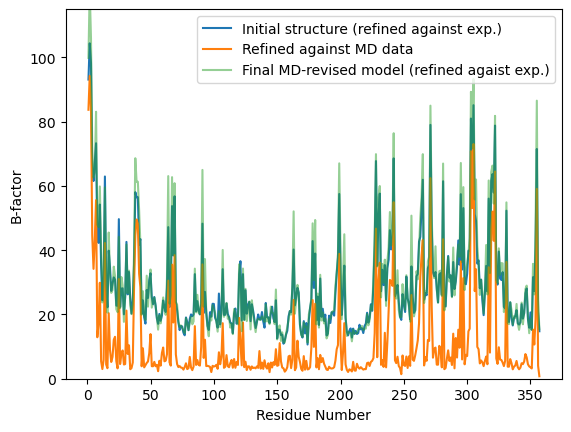

In [28]:
import matplotlib.pyplot as plt
import numpy as np

initial = iotbx.pdb.input(file_name="starting_structure_refinement_against_experiment_1.pdb").construct_hierarchy()
MD      = iotbx.pdb.input(file_name="single_structure_protein_first_waters_refine_2.pdb").construct_hierarchy()
final   = iotbx.pdb.input(file_name="single_structure_protein_first_refinement_against_exp_1.pdb").construct_hierarchy()

def get_bfacs(hierarchy):
    bfacs = []
    for chain in hierarchy.chains():
        for res in chain.residues():
            if res.resname not in ["HOH","MG", "ADP", "PO4"]:
                bfac  = 0
                atoms = 0
                for atom in res.atoms():
                    bfac += atom.b
                    atoms += 1
                bfacs.append(bfac/atoms)
    
    return bfacs
    
initial_bfactors = get_bfacs(initial)
MD_bfactors = get_bfacs(MD)
final_bfactors = get_bfacs(final)
    
plt.plot(np.arange(len(initial_bfactors))+1,np.array(initial_bfactors), label="Initial structure (refined against exp.)")
plt.plot(np.arange(len(MD_bfactors))+1,np.array(MD_bfactors), label="Refined against MD data")
plt.plot(np.arange(len(final_bfactors))+1,np.array(final_bfactors), alpha=0.5, label="Final MD-revised model (refined agaist exp.)")
plt.ylim([0,115])
#plt.xlim([1,370])
plt.xlabel("Residue Number");
plt.ylabel("B-factor");
plt.legend();

So, as we might expect from how similar the coordinates of the structural models are, the B-factors for both of the refinements against experimental data seem pretty similar. 

But...

Wow, those B-factors for the model refined against MD data seem pretty low... What's going on there?

Well, the PKA simulation from which we computed the structure factors was _restrained_ to the crystal structure, so the fluctuations of all the heavy atoms are suppressed by the restraints! 

Let's compare with the B-factors from a structure that was refined against the MD data in exactly the same way, but using structure factors computed from a simulation that was *unrestrained*.

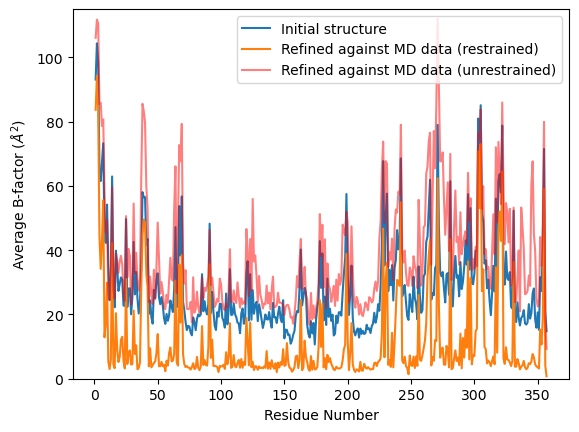

In [29]:
final_unrestrained = iotbx.pdb.input(file_name="./data/unrestrained_single_structure_protein_first_waters_refine_2.pdb").construct_hierarchy()
unrestrained_bfactors = get_bfacs(final_unrestrained)

plt.plot(np.arange(len(initial_bfactors))+1,np.array(initial_bfactors), label="Initial structure")
plt.plot(np.arange(len(MD_bfactors))+1,np.array(MD_bfactors), label="Refined against MD data (restrained)  ")
plt.plot(np.arange(len(unrestrained_bfactors))+1,np.array(unrestrained_bfactors), color="red", label="Refined against MD data (unrestrained)", alpha=0.5)
plt.ylim([0,115])
plt.xlabel("Residue Number");
plt.ylabel(r"Average B-factor ($\AA^{2}$)");
plt.legend();

Much better!

Why wouldn't we just use the structure factors from the simulation that was unrestrained for refinement? Well, let's examine the structures...

If you open them in `coot` and search around the structure, you should see something like the below image in certain regions, with the single structure refined against experimental data in yellow, the structure refined against restrained MD data in green, and the structure refined against *unrestrained* MD data in pink.

As you can hopefully see, the structure in pink which was refined against the MD data from an unrestrained simulation are systematically different from those of the refinement against experimental data, and the restrained MD simulation.

This is common feature of crystalline MD simulations: the _unrestrained_ simulation reproduces the B-factors very well, but doesn't reproduce the _average structure_ very well (this is often called "drift" in the literature). The force field is not able to reproduce the average structure without restraints, but it can reproduce the small-scale harmonic fluctuations which are modeled by the B-factors.

![coot comparison](./images/coot_comparison_exp_MD_restrained_and_unrestrained.png)

## Reverse-propagating a frame of the supercell simulation to create a protien structural ensemble

Another useful thing we can do with the MD trajectory is compute an ensmeble from each frame of the supercell simluation. By simulating (in our case) 32 copies of the protein at once, we can think of the trajectory as a simulation of an _ensemble_ of proteins rather than thinking of the trajectory as a simulation of the protein crystal. In this directory we've placed a sample frame from our PKA crystalling MD trajectory. The code below uses this sample frame, and the starting structure `.pdb` file we used for the refinement above to produce an ensemble of protein structures, superimposed on the asymmetric unit.

The code achieves this by testing all of the unit cell translation and crystal symmetry operations possible for each protein in the supercell, and finding the appropriate transformations to map the protein back on to the asymmetric unit. There are four proteins per unit cell in our simulation, and eight unit cells, for a total of 32 proteins in the ensemble.

You can view this ensemble model in the software of your choice (`coot`, `Chimera(X)`, `VMD`, `pymol`, etc.).

In [22]:
import scitbx.matrix
import itertools
import string

def reverse_propagate_supercell(supercell_pdb_filename, xrs_pdb_filename):
    '''

    Parameters
    ----------
    supercell_pdb_filename : str
        filename of supercell pdb file

    xrs_pdb_filename : str
        filename of x-ray structure file

    Returns
    -------
    ens : iotbx_pdb_hierarchy_ext.root
        cctbx hierarchy object for the ensemble
    '''
    
    def _get_unit_cell_vectors(xray_structure):
        A, B, C, alpha, beta, gamma = xray_structure.crystal_symmetry().unit_cell().parameters()
        cg = np.cos(np.radians(gamma))
        sg = np.sin(np.radians(gamma))
        cb = np.cos(np.radians(beta))
        ca = np.cos(np.radians(alpha))
        c1 = (ca - cb * cg) / sg

        avec = np.array([A, 0.0, 0.0])
        bvec = np.array([B * cg, B * sg, 0.0])
        cvec = np.array([C * cb, C * c1, C * np.sqrt(1 - cb * cb - c1 * c1)])

        for vec in [avec, bvec, cvec]:
            for i in range(3):
                if np.isclose(vec[i], 0.0, atol=0.0001):
                    vec[i] = 0.0
        
        return avec, bvec, cvec

    def map_back(chain, model, tol=2.0):
        print("mapping back chain {}...".format(c+1))
        found = False

        options = []
        for uc_translation in uc_t:
            for i in range(per_unit_cell):
                options.append((uc_translation, i))

        UC_T, RMAT, TVEC = (None, None, None)
        for option in options:
            working_chain = chain.detached_copy()
            for atom in working_chain.atoms():
                atom.set_xyz(tuple(np.array(atom.xyz)+option[0]))
            xyz = working_chain.atoms().extract_xyz()
            coords_frac = xrs.crystal_symmetry().unit_cell().fractionalize(xyz)
            new_xyz = xrs.crystal_symmetry().unit_cell().orthogonalize(rmats[option[1]].elems * (coords_frac - tvecs[option[1]]))
            working_chain.atoms().set_xyz(new_xyz)
            avg_coord = np.mean(np.array(new_xyz), axis=0)
            if np.linalg.norm(avg_coord-avg_coord_xrs) < tol:
                UC_T = option[0]
                RMAT = rmats[option[1]]
                TVEC = tvecs[option[1]]
                break

        assert (UC_T is not None) and (RMAT is not None) and (TVEC is not None), "not able to find a mapping back on to the asymmetric unit. Try increasing the tolerace (tol) in the method map_back (default: tol=2.0)"
        
        # move unit cells back to original unit cell position
        # and reset i_seq
        for atom in chain.atoms():
            atom.set_xyz(tuple(np.array(atom.xyz) + UC_T))

        # then reverse the space group symmetry operations
        xyz = chain.atoms().extract_xyz()
        xyz = xrs.crystal_symmetry().unit_cell().fractionalize(xyz)
        new_xyz = xrs.crystal_symmetry().unit_cell().orthogonalize(RMAT.elems * (xyz - TVEC))
        chain.atoms().set_xyz(new_xyz)

        resid = 1
        for new_res in chain.residue_groups():
            new_res.resseq = resid
            resid += 1
    
    # load in the files for the supercell and crystal structure
    supercell_pdb = iotbx.pdb.input(file_name=supercell_pdb_filename)
    xrs_pdb       = iotbx.pdb.input(file_name=xrs_pdb_filename)
    SC  = supercell_pdb.construct_hierarchy(sort_atoms=False)
    xrs = xrs_pdb.xray_structure_simple()
    
    # unit cell vectors
    avec, bvec, cvec = _get_unit_cell_vectors(xrs)
    avec_SC, bvec_SC, cvec_SC = _get_unit_cell_vectors(supercell_pdb.xray_structure_simple())
    
    # number of unit cells along each axis and total number of unit cells in supercell
    nA = int(np.linalg.norm(avec_SC)/np.linalg.norm(avec))
    nB = int(np.linalg.norm(bvec_SC)/np.linalg.norm(bvec))
    nC = int(np.linalg.norm(cvec_SC)/np.linalg.norm(cvec))
    num_unit_cells = nA * nB * nC
    
    # space group and symmetry operations
    space_group = xrs.crystal_symmetry().space_group()
    space_group_ops = space_group.all_ops()
    
    # chains per unit cell
    per_unit_cell = len(space_group_ops)
    
    # residues and atoms per copy of the molecule
    residues_per_copy = int(SC.overall_counts().n_residues/(num_unit_cells * per_unit_cell))
    atoms_per_copy = int(SC.overall_counts().n_atoms/(num_unit_cells * per_unit_cell))
    
    # space group symmetry rotation matrices and translation vectors
    rmats = [scitbx.matrix.sqr(m.r().as_double()) for m in space_group_ops]
    tvecs = [m.t().as_double() for m in space_group_ops]

    # inverse unit translation vector for each cell
    # i.e. the vector that sends each cell back
    # to the asu-containing unit cell
    iut_cells = -1 * np.array([el for el in itertools.product(range(nA), range(nB), range(nC))])

    # unit cell translation vectors
    uc_t = []
    for indices in iut_cells:
        uc_t.append(avec * indices[0] + bvec * indices[1] + cvec * indices[2])

    # chain ids for the ensemble
    idl = [char for char in string.ascii_lowercase]
    idu = [char for char in string.ascii_uppercase]
    chain_ids = idl + idu
    
    # average coordinate of the x-ray structure
    avg_coord_xrs = np.mean(np.array([atom.xyz for atom in xrs_pdb.construct_hierarchy().atoms()]), axis=0)

    # empty ensemble objects
    ens = iotbx.pdb.hierarchy.root()
    
    # chain and atom counters
    c = 0
    atom_count = 0
    
    # first empty model and chain
    model = iotbx.pdb.hierarchy.model(id="{}".format(c+1))
    chain = iotbx.pdb.hierarchy.chain(id=chain_ids[c])
    
    # go through the supercell, filling the chains/models
    # until you reach the end of each protein
    for sc_chain in SC.chains():
        for res in sc_chain.residue_groups():
            res_atoms = [a for a in res.atoms()]
            atom_count += len(res_atoms)
            # keep appending residues if we haven't reached the end of the chain
            if (atom_count-1) // atoms_per_copy == c:
                chain.append_residue_group(res.detached_copy())

            else:
                # find the right symmetry operations to map back onto ASU
                map_back(chain, model)
                    
                # add the model to the ensemble
                model.append_chain(chain)
                ens.append_model(model)
                
                # increment the chain counter
                c = (atom_count-1) // atoms_per_copy
                
                # create a new empty model and chain
                model = iotbx.pdb.hierarchy.model(id="{}".format(c+1))
                chain = iotbx.pdb.hierarchy.chain(id=chain_ids[c])
                
                chain.append_residue_group(res.detached_copy())

    # last chain
    map_back(chain, model)
    model.append_chain(chain)
    ens.append_model(model)
    
    # clean things up
    ens.atoms_reset_serial()
    
    return ens

We're going to reverse-propagate a sample frame from the simulation that was used to produce the structure factor data we used in the refinement above. If you open the sample frame in a visualization software like ChimeraX, it looks something like this:

![supercell image](./images/supercell.png)

We're going to take each of those proteins, and map them back to the asymmetric unit so we can examine all of them, superimposed, at once.

In [23]:
# get the ensemble and write it out
ensemble = reverse_propagate_supercell("./data/supercell_sample_frame.pdb", 
                                       "./files_for_refinement/starting_structure.pdb")
xtal_symmetry = iotbx.pdb.input(file_name="./files_for_refinement/starting_structure.pdb").xray_structure_simple()
ensemble.write_pdb_file("ensemble.pdb", crystal_symmetry=xtal_symmetry)

mapping back chain 1...
mapping back chain 2...
mapping back chain 3...
mapping back chain 4...
mapping back chain 5...
mapping back chain 6...
mapping back chain 7...
mapping back chain 8...
mapping back chain 9...
mapping back chain 10...
mapping back chain 11...
mapping back chain 12...
mapping back chain 13...
mapping back chain 14...
mapping back chain 15...
mapping back chain 16...
mapping back chain 17...
mapping back chain 18...
mapping back chain 19...
mapping back chain 20...
mapping back chain 21...
mapping back chain 22...
mapping back chain 23...
mapping back chain 24...
mapping back chain 25...
mapping back chain 26...
mapping back chain 27...
mapping back chain 28...
mapping back chain 29...
mapping back chain 30...
mapping back chain 31...
mapping back chain 32...


_Note: cctbx introduces `BREAK` records in to the model when it writes out the pdb file -- these must be removed before we can inspect the model in `coot`_

In [24]:
!grep -v "BREAK" ensemble.pdb > ensemble_cleaned.pdb

When you open the structure `ensemble_cleaned.pdb` in coot, you should see something like this:

![coot ensemble](./images/coot_ensemble.png)

Here's what it looks like in `UCSF ChimeraX`, for a bit of a better view of the regions of order and disorder:

![Chimera ensemble](./images/ensemble.gif)

There we are! That's the ensemble of protien structures represented in just a single frame from our MD simulation!

---

In our [_Acta Cryst. D_ paper](https://journals.iucr.org/d/issues/2023/01/00/lp5065/), we used this ensemble as a complement to the Bragg analysis, to identify regions of the model where a multi-conformer structural model might be appropriate. This MD ensemble allowed us to identify an activate site residue that is well-modeled by a two-state multiconformer model, and a peptide flip multiconformer model in another region.